# Deep Generative Adversarial Networks sur la base de données MNIST
Les DCGAN sont des GANs spécifiques dont le discriminateur est un réseau de neurones convolutif et le générateur un réseau de neurones composé de convolutions transposées.

Pour implémenter le DCGAN, nous nous baserons sur la base de données Tensorflow MNIST qui représente des chiffres écrits à la main.

## Importation des librairies

In [1]:
#tensorflow
import tensorflow as tf



import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## Chargement des données
Nous utilisons la base de données MNIST poour entrainer le générateur and le discriminateur. Le générareur va générer des chiffres écrits à la main ressemblant aux données MNIST.

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Modèle

### Le générateur
Le générateur a pour objectif de générer des chiffres manuscrits en prennant pour modèle la base de données MNIST. 

Le générateur produit une image à partir d'un bruit aléatoire en utilisant les couches de `tf.keras.layers.Conv2DTranspose`. On commence avec une couche Dense (`tf.keras.layers.Dense`), où tous les neurones sont liés entre eux, qui prend ce bruit aléatoire en entrée, puis on sur-échantillonne plusieurs fois jusqu'à atteindre la taille désirée de l'image (28x28x1). On utilise une activation LeakyReLu (`tf.keras.layers.LeakyReLU`) pour toutes les couches, sauf la couche de sortie pour laquelle on utilise une activation Tahn.

In [6]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

On utilise le générateur même s'il n'a pas été entrainé, pour générer une image. Le modèle s'entrainera pour générer des images ressemblantes à celle de la base de données MNIST

In [7]:
generator = generator_model()

noise = tf.random.normal([1, 100]) #bruit aléatoire
image = generator(noise, training=False)

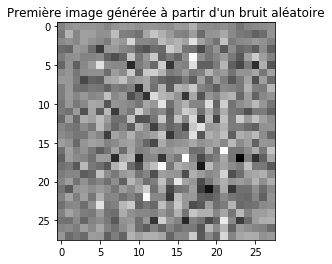

In [8]:
plt.title("Première image générée à partir d'un bruit aléatoire")
plt.imshow(image[0, :, :, 0], cmap='gray')

### Le discriminateur
Le discriminateur a pour objectif d'identifier les vraies images de chiffres manuscrits et les images générées par le générateur. 

Le discriminateur est un classifieur : il détermine la classe de l'image (vraie ou fausse). Nous utilisons un classifieur CNN (Convolutional Neural Network) classique, utilisé dans la classification d'image, en utilisant des couches de tf.keras.layers.Conv2D et une activation ReLu.  

In [9]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

On utilise le discriminateur même s'il n'a pas été entrainé, pour classifier les images générées comme vraies ou fausses. Le modèle s'entrainera pour sortir des valeurs positives pour les vraies images et négatives pour les fausses.

In [10]:
discriminator = discriminator_model()
decision = discriminator(image)
print(decision)

tf.Tensor([[4.8502323e-05]], shape=(1, 1), dtype=float32)


### Pertes et fonctions d'optimisation

#### Pertes
Les pertes du discriminateur et du générateur utilisent une cross-entropy binaire qui permet d'évaluer une perte dans le cadre d'une classification binaire.

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### Perte du discriminateur
La perte du discriminateur mesure à quel point le discriminateur est capable de distinguer les vraies images des fausses. Il compare les prédictions du discriminateur sur des vraies images à un array de 1, et sur des fausses images à un array de 0. 

La perte du discriminateur est donc égale à la somme de deux pertes : 
* perte sur la classification de vraies images : à quel point le discriminateur réussit à déterminer qu'une vraie image est vraie
* perte sur la classification de fausses images : à quel point le discriminateur réussit à déterminer qu'une fausse image est fausse

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

##### Perte du générateur
La perte du générateur mesure à quel point le générateur est capable de tromper le discriminateur. Intuitivement, si le générateur performe bien, le discriminateur va classifier toutes les fausses images comme des vraies. On compare ici les décisions du discriminateur sur les images générées à un array de 1. 

La perte du générateur est donc égale à - la perte de classification de faux du discriminateur : à quel point le discriminateur se trompe et détermine qu'une fausse image est vraie.

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Les fonctions d'optimisation
Les fonctions d'optimisation du discriminateur et du générateur diffèrent car on entraine deux réseaux de neurones séparément.

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Entrainement

In [22]:
EPOCHS = 40
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Une boucle d'entrainement se déroule en 3 étapes : 
1. Le générateur reçoit la seed aléatoire comme input et l'utilise pour produire une image. 
2. Le discriminateur classifie les vraies images (issues du set d'entrainement) et les fausses images (produites par le générateur). 
3. La perte est calculée pour les deux modèles, et les gradients sont utilisés pour mettre à jour le générateur et le discriminateur.

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
#         if (epoch + 1) % 15 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [18]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Entrainement du modèle
Au début de l'entrainement, les images générées ressemblent à des bruits aléatoires. Puis, au fur et à mesure de l'entrainement, des chiffres manuscrits très réalistes apparaissent. Au bout de 40 epochs, ils ressemblent aux chiffres MNIST. 

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### GIF

In [20]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

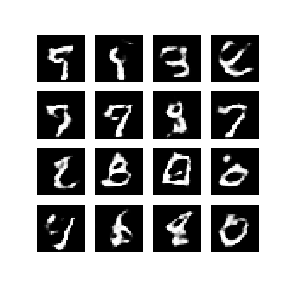

In [23]:
display_image(EPOCHS)

In [24]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)